## Part One

In [1]:
test_input = """47|53
97|13
97|61
97|47
75|29
61|13
75|53
29|13
97|29
53|29
61|53
97|53
61|29
47|13
75|47
97|75
47|61
75|61
47|29
75|13
53|13

75,47,61,53,29
97,61,53,29,13
75,29,13
75,97,47,61,53
61,13,29
97,13,75,29,47
"""

In [2]:
rule_rows = []
updates = []

for line in test_input.splitlines():
    line = line.strip()
    if line:
        if line.find("|") != -1:
            rule_rows.append([int(fld) for fld in line.split("|")])
        else:
            updates.append([int(fld) for fld in line.split(",")])

In [3]:
rule_rows

[[47, 53],
 [97, 13],
 [97, 61],
 [97, 47],
 [75, 29],
 [61, 13],
 [75, 53],
 [29, 13],
 [97, 29],
 [53, 29],
 [61, 53],
 [97, 53],
 [61, 29],
 [47, 13],
 [75, 47],
 [97, 75],
 [47, 61],
 [75, 61],
 [47, 29],
 [75, 13],
 [53, 13]]

In [4]:
updates

[[75, 47, 61, 53, 29],
 [97, 61, 53, 29, 13],
 [75, 29, 13],
 [75, 97, 47, 61, 53],
 [61, 13, 29],
 [97, 13, 75, 29, 47]]

The rules suggest a graph. Updates need to be in topologically sorted order.

In [5]:
import networkx as nx

In [6]:
graph = nx.DiGraph()
graph.add_edges_from(rule_rows)

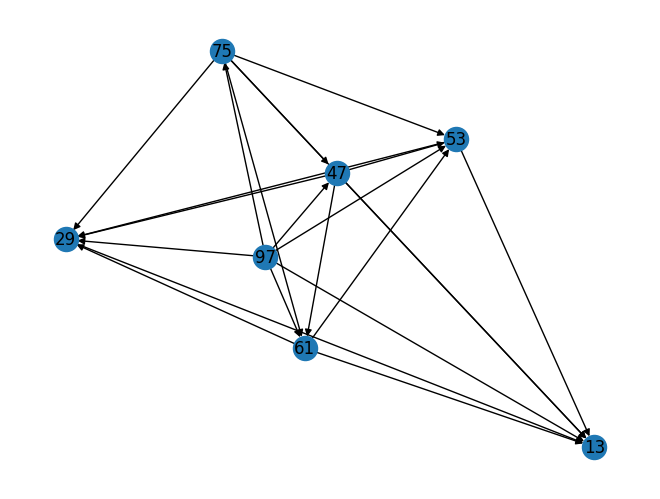

In [7]:
nx.draw(graph, with_labels=True)

In [8]:
list(nx.topological_sort(graph))

[97, 75, 47, 61, 53, 29, 13]

Actually I don't need topological sort. All I need to do is to verify that each update is in topological sorted order. This means all I have to do is check if path exists between the current node and all the following nodes.
```
foreach node in update
  get all node's followers
  foreach follower in followers
    check if there is a path from node to follower
```
Checking for a path is O(N) op because presumably I'll have to traverse all the nodes to find the path. This takes me to O(N^3)!!

Or I can take the topolicaly sorted output as my single rule and build a dict of sets where each node points to all its following nodes stored in a set. Now, given an update, checking whether each of the following node is reachable becomes an O(1) op taking my algo to O(N^2). The sorted order is non-unique, but I don't think it will matter once I convert it into a dict of sets data structure.

But do I need the intermediate step of topologically sorting the graph? Can't I just make my dict of sets from the rule tuples? Let me see -

In [9]:
rule = list(nx.topological_sort(graph))
rule

[97, 75, 47, 61, 53, 29, 13]

In [10]:
rules = {}
for i in range(len(rule)):
    node = rule[i]
    followers = set(rule[i + 1:])
    rules[node] = followers
rules


{97: {13, 29, 47, 53, 61, 75},
 75: {13, 29, 47, 53, 61},
 47: {13, 29, 53, 61},
 61: {13, 29, 53},
 53: {13, 29},
 29: {13},
 13: set()}

In [11]:
from collections import defaultdict

In [12]:
rules = defaultdict(set)
for rule_row in rule_rows:
    fst, snd = rule_row
    rules[fst].add(snd)
rules

defaultdict(set,
            {47: {13, 29, 53, 61},
             97: {13, 29, 47, 53, 61, 75},
             75: {13, 29, 47, 53, 61},
             61: {13, 29, 53},
             29: {13},
             53: {13, 29}})

If there is an indirect path it won't show up without toposort. Say I have rules -
```
X|Y
Y|Z
```
My naive dict/set will not include the implicit rule `X|Z`, but the toposort will catch it.

In [13]:
def is_valid(update):
    for i in range(len(update)):
        node = update[i]
        update_followers = update[i + 1:]
        rules_followers = rules[node]
        for update_follower in update_followers:
            if update_follower not in rules_followers:
                return False
    return True

In [14]:
valid_updates = filter(is_valid, updates)
list(valid_updates)

[[75, 47, 61, 53, 29], [97, 61, 53, 29, 13], [75, 29, 13]]

In [15]:
from functools import reduce

In [16]:
reduce(
    lambda acc, update: acc + update[len(update) // 2],
    filter(is_valid, updates),
    0
)

143

Turns out the actual input has cycles in it, so I cannot use this approach. It is probably because of this statement in problem -
> Because the first update does not include some page numbers, the ordering rules involving those missing page numbers are ignored.

Modified algo -
```
foreach update in updates
  filter rules to those that have each page in this update
  build the graph
  toposort it
  create the dict of sets data structure
  for each page in this update
    check that all the following pages are valid
```
Filtering rules is going to be O(R), building and sorting the graph is going to be O(R), creating the dict of sets is also going to be O(R). Finally checking each page is going to be O(P^2), where R is the number of rules and P is the number of pages in an update. And all of this has to be done for all updates so it comes out to O(UP^2R) - so somewhere in the cubed range.

In [18]:
update = [61, 13, 29]
filtered_rules = list(filter(lambda fs: fs[0] in update and fs[1] in update, rule_rows))
filtered_rules

[[61, 13], [29, 13], [61, 29]]

In [19]:
graph = nx.DiGraph()
graph.add_edges_from(filtered_rules)
rule = list(nx.topological_sort(graph))
rule

[61, 29, 13]

In [20]:
new_graph = {}
for i in range(len(rule)):
    page = rule[i]
    followers = set(rule[i + 1:])
    new_graph[page] = followers
new_graph

{61: {13, 29}, 29: {13}, 13: set()}

## Part Two

In [24]:
%reset

In [25]:
import solution as s1

In [27]:
test_input = """47|53
97|13
97|61
97|47
75|29
61|13
75|53
29|13
97|29
53|29
61|53
97|53
61|29
47|13
75|47
97|75
47|61
75|61
47|29
75|13
53|13

75,47,61,53,29
97,61,53,29,13
75,29,13
75,97,47,61,53
61,13,29
97,13,75,29,47
"""

In [28]:
rule_rows = []
updates = []

for line in test_input.splitlines():
    line = line.strip()
    if line:
        if line.find("|") != -1:
            rule_rows.append([int(fld) for fld in line.split("|")])
        else:
            updates.append([int(fld) for fld in line.split(",")])

In [29]:
update = updates[3]
update

[75, 97, 47, 61, 53]

In [32]:
filtered_rules = s1.filter_rules(rule_rows, update)
valid_order = s1.consolidate_rule(filtered_rules)
valid_order

[97, 75, 47, 61, 53]

The valid order is simply the output of the toposort, so really my consolidated rule. However, topsorts are not unique, so the sum of the middle pages might vary? Or maybe their input is such that topsort is always unique? Probably good to confirm that.